In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

import cheetah
import tests.resources.ARESlatticeStage3v1_9 as ocelot_lattice

math_op.py: module Numba is not installed. Install it if you want speed up correlation calculations


[INFO    ] : : beam.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] : : : : : : : : high_order.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation
[INFO    ] wake3D.py: module NUMBA is not installed. Install it to speed up calculation


initializing ocelot...
import: module NUMBA is not installed. Install it to speed up calculation
import: module PYFFTW is not installed. Install it to speed up calculation
import: module NUMEXPR is not installed. Install it to speed up calculation


In [2]:
# Setup ARES EA
ares_segment = cheetah.Segment.from_ocelot(
    ocelot_lattice.cell, warnings=False, device="cpu"
).subcell("AREASOLA1", "AREABSCR1")

ares_segment.AREABSCR1.resolution = (2448, 2040)
ares_segment.AREABSCR1.pixel_size = (3.3198e-6, 2.4469e-6)
ares_segment.AREABSCR1.binning = 1
ares_segment.AREABSCR1.is_active = True

In [3]:
incoming_parameters = torch.tensor(
    [80e6, -1e-3, -1e-4, -1e-3, -1e-4, 1e-5, 1e-6, 1e-5, 1e-6, 1e-6, 1e-4]
)
ares_incoming_beam = cheetah.ParameterBeam.from_parameters(
    energy=incoming_parameters[0],
    mu_x=incoming_parameters[1],
    mu_xp=incoming_parameters[2],
    mu_y=incoming_parameters[3],
    mu_yp=incoming_parameters[4],
    sigma_x=incoming_parameters[5],
    sigma_xp=incoming_parameters[6],
    sigma_y=incoming_parameters[7],
    sigma_yp=incoming_parameters[8],
    sigma_s=incoming_parameters[9],
    sigma_p=incoming_parameters[10],
)

In [4]:
ares_segment.length

tensor(2.0460)

In [5]:
len(ares_segment.elements)

13

In [6]:
%%timeit
ares_segment.track(ares_incoming_beam)

783 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
# Setup part of LCLS from RL work

# This is a hack, because there are many elements named like the one we want to
# start with ("daq1"). The element upstream of the correct "daq1" uinqie and
# named "k26_1d". Hence, we take the segment that is one element too long in
# upstream direction and then remove that element.
os.environ["LCLS_LATTICE"] = str(Path("../lcls-lattice").absolute())
cu_hxr_file_path = (
    Path("$LCLS_LATTICE") / "bmad" / "models" / "cu_hxr" / "cu_hxr.lat.bmad"
)
lcls_lattice_dir = os.environ["LCLS_LATTICE"]
too_long_segment = (
    cheetah.Segment.from_bmad(
        str(cu_hxr_file_path),
        environment_variables={"LCLS_LATTICE": lcls_lattice_dir},
    )
    .flattened()
    .subcell("k26_1d", "begundh")
)
lcls_segment = cheetah.Segment(
    elements=too_long_segment.elements[1:], name=too_long_segment.name
)
for element in lcls_segment.elements:
    if isinstance(element, cheetah.Aperture):
        element.is_active = False
# Check that first quad is correct one and in the expected place
assert lcls_segment.elements[1].name == "q26201"

In [8]:
lcls_incoming_beam = cheetah.ParameterBeam.from_twiss(
    beta_x=torch.tensor(61.47503078),
    alpha_x=torch.tensor(-1.21242463),
    emittance_x=torch.tensor(7.1971891e-13),
    beta_y=torch.tensor(35.41897281),
    alpha_y=torch.tensor(0.66554622),
    emittance_y=torch.tensor(3.5866484e-15),
    energy=torch.tensor(6.6504429e9),
)

In [9]:
lcls_segment.length

tensor(1004.1179)

In [10]:
len(lcls_segment.elements)

887

In [11]:
%%timeit
lcls_segment.track(lcls_incoming_beam)

336 ms ± 793 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
sum(
    hasattr(element, "is_active") and element.is_active
    for element in lcls_segment.elements
)

tensor(129)

In [13]:
reduced_elements = lcls_segment.elements
# Remove inactive Markers
reduced_elements = [
    element
    for element in lcls_segment.elements
    if not isinstance(element, cheetah.Marker)
]
# Remove inactive elements without length or length 0.0
reduced_elements = [
    element
    for element in reduced_elements
    if (hasattr(element, "length") and element.length > 0.0)
    or (hasattr(element, "is_active") and element.is_active)
]
# Replace inactive elements with drifts
reduced_elements = [
    (
        element
        if (hasattr(element, "is_active") and element.is_active)
        or not hasattr(element, "length")
        else cheetah.Drift(element.length)
    )
    for element in reduced_elements
]

lcls_test_segment = cheetah.Segment(elements=reduced_elements, name=lcls_segment.name)

lcls_test_segment = lcls_test_segment.transfer_maps_merged(
    incoming_beam=lcls_incoming_beam,
    except_for=[
        "q26201",
        "q26301",
        "q26401",
        "q26501",
        "q26601",
        "q26701",
        "q26801",
        "q26901",
        "cq31",
        "cq32",
        "qem1",
        "qem2",
        "qem3",
        "qem4",
    ],
)

In [14]:
lcls_test_segment.length

tensor(1004.1180)

In [15]:
len(lcls_test_segment.elements)

60

In [16]:
%%timeit
lcls_test_segment.track(lcls_incoming_beam)

17.2 ms ± 46.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
cheetah.CustomTransferMap.from_merging_elements

<bound method CustomTransferMap.from_merging_elements of <class 'cheetah.accelerator.CustomTransferMap'>>

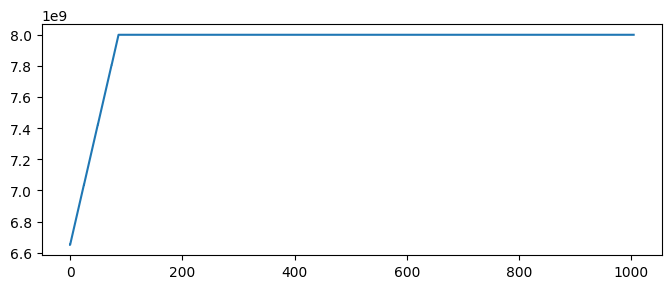

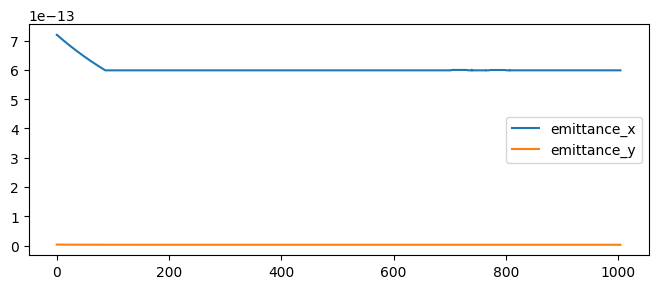

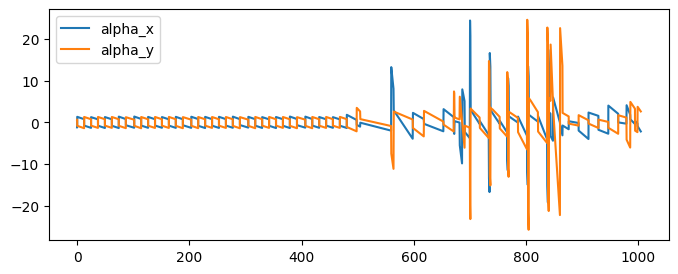

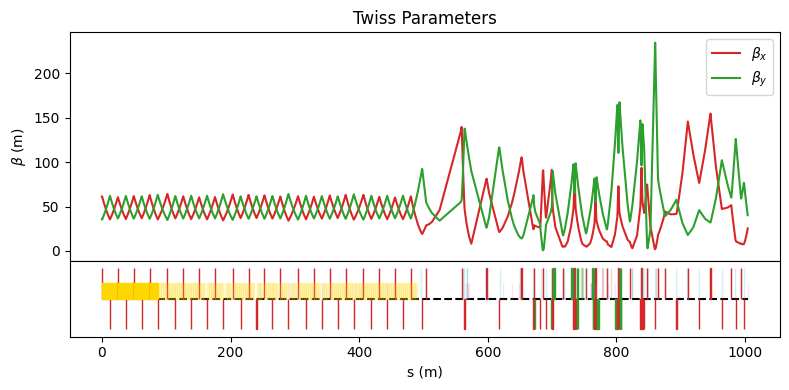

In [18]:
saved_beams = [lcls_incoming_beam]
ss = [0.0]
for element in lcls_segment.elements:
    if not hasattr(element, "length"):
        continue

    tmp_beam = element.track(saved_beams[-1])
    saved_beams.append(tmp_beam)
    ss.append(ss[-1] + element.length)

plt.figure(figsize=(8, 3))
plt.plot(ss, [beam.energy for beam in saved_beams])
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(ss, [beam.emittance_x for beam in saved_beams], label="emittance_x")
plt.plot(ss, [beam.emittance_y for beam in saved_beams], label="emittance_y")
plt.legend()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(ss, [beam.alpha_x for beam in saved_beams], label="alpha_x")
plt.plot(ss, [beam.alpha_y for beam in saved_beams], label="alpha_y")
plt.legend()
plt.show()

# --------------------

lcls_segment.plot_twiss_over_lattice(beam=lcls_incoming_beam)

lcls_segment_ss = ss
lcls_segment_saved_beams = saved_beams

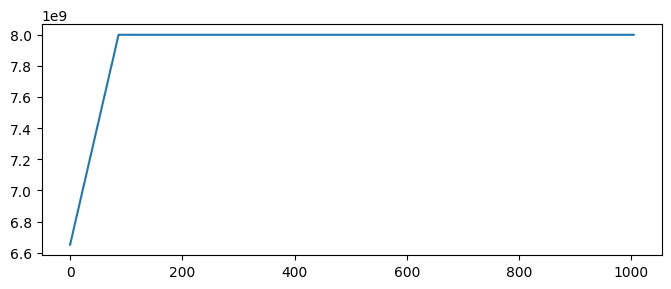

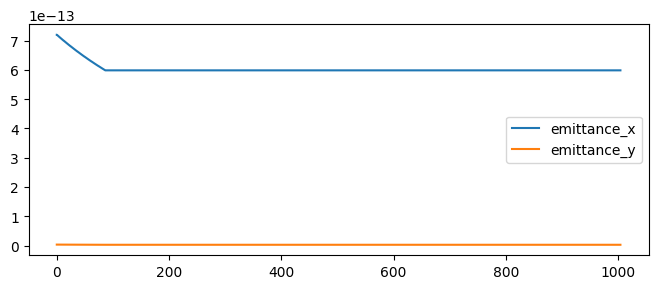

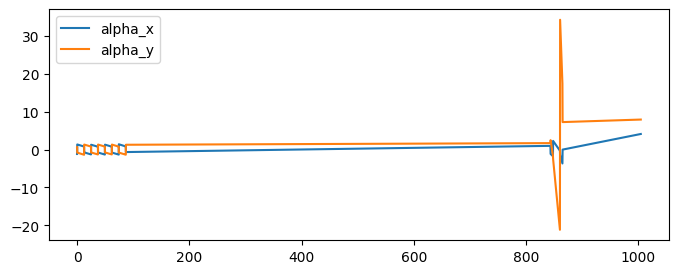

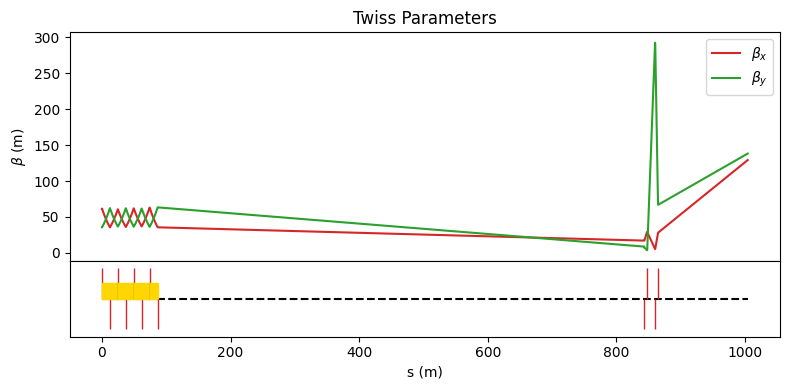

In [19]:
saved_beams = [lcls_incoming_beam]
ss = [0.0]
for element in lcls_test_segment.elements:
    if not hasattr(element, "length"):
        continue

    tmp_beam = element.track(saved_beams[-1])
    saved_beams.append(tmp_beam)
    ss.append(ss[-1] + element.length)

plt.figure(figsize=(8, 3))
plt.plot(ss, [beam.energy for beam in saved_beams])
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(ss, [beam.emittance_x for beam in saved_beams], label="emittance_x")
plt.plot(ss, [beam.emittance_y for beam in saved_beams], label="emittance_y")
plt.legend()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(ss, [beam.alpha_x for beam in saved_beams], label="alpha_x")
plt.plot(ss, [beam.alpha_y for beam in saved_beams], label="alpha_y")
plt.legend()
plt.show()

# --------------------

lcls_test_segment.plot_twiss_over_lattice(beam=lcls_incoming_beam)

lcls_test_segment_ss = ss
lcls_test_segment_saved_beams = saved_beams

In [20]:
reduced_beams = [
    beam
    for s, beam in zip(lcls_segment_ss, lcls_segment_saved_beams)
    if any(np.isclose(s, reference_s) for reference_s in lcls_test_segment_ss)
]

In [21]:
len(reduced_beams)

61

In [22]:
len(lcls_test_segment_saved_beams)

61

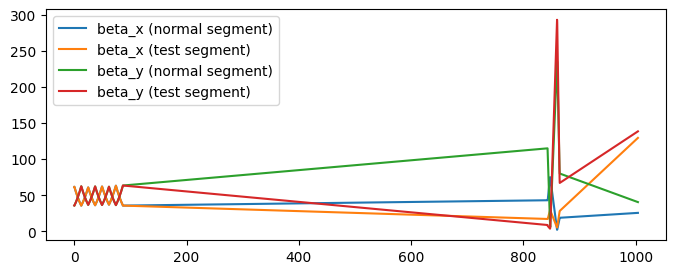

In [25]:
plt.figure(figsize=(8, 3))
plt.plot(
    lcls_test_segment_ss,
    [beam.beta_x for beam in reduced_beams],
    label="beta_x (normal segment)",
)
plt.plot(
    lcls_test_segment_ss,
    [beam.beta_x for beam in lcls_test_segment_saved_beams],
    label="beta_x (test segment)",
)
plt.plot(
    lcls_test_segment_ss,
    [beam.beta_y for beam in reduced_beams],
    label="beta_y (normal segment)",
)
plt.plot(
    lcls_test_segment_ss,
    [beam.beta_y for beam in lcls_test_segment_saved_beams],
    label="beta_y (test segment)",
)
plt.legend()
plt.show()

In [24]:
lcls_test_segment_ss[13] in lcls_segment_ss

True